# 승촌보 데이터 분석 

* 승촌보 수질 데이터(Seungchonbo.xlsx)   
    * 2012-2022년  
    * 시간 단위 수집 데이터
* 승촌보 유량 데이터(Seungchonbo_flow.xlsx)
    * 2012-2022년
    * 10분 단위 수집 데이터

**필수 모듈 임포트**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from datetime import datetime
import datetime as dt

**훈련 모델 준비**

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

**matplotlib 한글 설정**

In [3]:
# 운영체제에 따른 한글 지원을 설정한다. 지원되는 환경은 윈도우, 우분투, 구글 코랩 등이다.

import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

## 승촌보 데이터 불러오기

### 수질 데이터 불러오기

**보 이름**

In [4]:
weir = 'Seungchonbo'

**데이터 저장소**

In [5]:
base_path = "https://github.com/codingalzi/water-data/raw/master/reservoirs/"

**시간 단위로 측정된 승촌보 연도별 수질 데이터 불러오기**

`'측정일/월'` 특성은 date time으로 파싱.

In [6]:
# ! pip install openpyxl

In [7]:
# '측정일/월' 특성은 date time으로 파싱.
# 반환값은 연도별 데이터프레임으로 구성된 사전. 2012년 ~ 2022년

data_file = weir+".xlsx"
scb_yearly = pd.read_excel(base_path+data_file, 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 측정일/월 특성을 date time으로 파싱

**2012년도 데이터를 제외한 모든 데이터 통합 함수**

2012년도 데이터는 결측치가 너무 많음.

In [8]:
# 2013년도 데이터부터 합침
# 반환값은 데이터프레임

def concat_yearly_df(df_yearly_dict):
    df_concat = pd.DataFrame()

    for year in list(df_yearly_dict.keys())[1:]:
        df_concat = pd.concat([df_concat, df_yearly_dict[year]])

    return df_concat

**연도별 수질 데이터 통합**

In [9]:
# 2013년도부터 통합
scb_yearly_df13 = concat_yearly_df(scb_yearly)

In [10]:
scb_yearly_df13.columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')

인덱스를 `'측정일/월'` 특성으로 변경한다.

In [11]:
scb_yearly_df13 = scb_yearly_df13.set_index('측정일/월')

인덱스의 이름도 변경한다.

In [12]:
scb_yearly_df13.index.name = 'date/time'

인덱스(`'date/time'`) 기준으로 정렬한다.

In [13]:
scb_yearly_df13 = scb_yearly_df13.sort_index()

In [14]:
scb_yearly_df13

,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
date/time,,,,,,,,,
2013-01-01 00:00:00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
2013-01-01 01:00:00,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2013-01-01 02:00:00,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
2013-01-01 03:00:00,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2013-01-01 04:00:00,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...
2022-05-23 19:00:00,용봉,26.6,6.9,419.0,NaN,6.7,5.825,0.108,66.2
2022-05-23 20:00:00,용봉,26.3,6.8,425.0,NaN,6.5,5.803,0.107,61.2
2022-05-23 21:00:00,용봉,25.9,6.8,417.0,NaN,6.7,5.909,0.107,58.3


### 유량 데이터 불러오기

**10분 단위로 측정된 승촌보 연도별 유량 데이터 불러오기**

In [15]:
# `시간` 특성은 date time으로 파싱해서 불러온다.
# 반환값은 연도별 데이터프레임으로 구성된 사전. 2012년 ~ 2022년

flow_data_file = weir+"_flow.xlsx"
scb_flow_yearly = pd.read_excel(base_path+flow_data_file, 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 시간 특성을 date time으로 파싱

수질 데이터셋과 맞추기 위해 2012년도 데이터를 제외한 데이터를 통합한다.

In [16]:
# 2013년부터 통합
scb_flow_yearly_df = concat_yearly_df(scb_flow_yearly)

In [17]:
scb_flow_yearly_df

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013-01-01 00:00:00,7.50,3.77,19.82,19.74
1,2013-01-01 00:10:00,7.50,3.77,19.78,19.76
2,2013-01-01 00:20:00,7.50,3.77,19.77,19.82
3,2013-01-01 00:30:00,7.50,3.77,19.77,19.73
4,2013-01-01 00:40:00,7.50,3.77,19.78,19.79
...,...,...,...,...,...
32947,2022-08-17 19:10:00,5.46,1.60,14.01,19.78
32948,2022-08-17 19:20:00,5.47,1.59,18.96,19.78
32949,2022-08-17 19:30:00,5.47,1.58,19.78,19.78
32950,2022-08-17 19:40:00,5.47,1.57,24.72,19.78


인덱스를 시간으로 지정

In [18]:
scb_flow_yearly_df = scb_flow_yearly_df.set_index('시간')

인덱스 이름도 수질 데이터와의 통합을 위해 동일한 이름으로 변경한다.

In [19]:
scb_flow_yearly_df.index.name = 'date/time'

시간 기준으로 정렬

In [20]:
scb_flow_yearly_df = scb_flow_yearly_df.sort_index()

In [21]:
scb_flow_yearly_df

,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
date/time,,,,
2013-01-01 00:00:00,7.50,3.77,19.82,19.74
2013-01-01 00:10:00,7.50,3.77,19.78,19.76
2013-01-01 00:20:00,7.50,3.77,19.77,19.82
2013-01-01 00:30:00,7.50,3.77,19.77,19.73
2013-01-01 00:40:00,7.50,3.77,19.78,19.79
...,...,...,...,...
2022-08-17 19:10:00,5.46,1.60,14.01,19.78
2022-08-17 19:20:00,5.47,1.59,18.96,19.78
2022-08-17 19:30:00,5.47,1.58,19.78,19.78


**10분 단위를 1시간 단위로 변경**

수질 데이터와의 통합을 위해 시간별 평균값을 활용한다.

In [22]:
scb_flow_yearly_hour_df = scb_flow_yearly_df.resample("H").mean()

In [23]:
scb_flow_yearly_hour_df

,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
date/time,,,,
2013-01-01 00:00:00,7.500000,3.770000,19.773333,19.748333
2013-01-01 01:00:00,7.500000,3.770000,19.701667,19.706667
2013-01-01 02:00:00,7.500000,3.770000,19.748333,19.723333
2013-01-01 03:00:00,7.500000,3.770000,19.613333,19.610000
2013-01-01 04:00:00,7.500000,3.770000,19.661667,19.665000
...,...,...,...,...
2022-08-17 15:00:00,5.536667,1.618333,29.261667,25.190000
2022-08-17 16:00:00,5.525000,1.638333,23.243333,38.923333
2022-08-17 17:00:00,5.483333,1.626667,29.068333,44.878333


### 수질/유량 데이터 합병

수질 데이터와 유량 데이터를 `date/time` 기준으로 합병한다.

In [24]:
# `pd.merge()`에서 `how = 'outer'` 키워드 인자 : 두 데이터에 사용된 모든 시간대의 데이터를 모두 추가한다(합집합).
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, left_index=True, right_index=True, how='outer')

In [25]:
scb_data

,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
date/time,,,,,,,,,,,,,
2013-01-01 00:00:00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2,7.500000,3.770000,19.773333,19.748333
2013-01-01 01:00:00,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9,7.500000,3.770000,19.701667,19.706667
2013-01-01 02:00:00,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8,7.500000,3.770000,19.748333,19.723333
2013-01-01 03:00:00,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9,7.500000,3.770000,19.613333,19.610000
2013-01-01 04:00:00,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9,7.500000,3.770000,19.661667,19.665000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.536667,1.618333,29.261667,25.190000
2022-08-17 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.525000,1.638333,23.243333,38.923333
2022-08-17 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.483333,1.626667,29.068333,44.878333


2022년도 유량 데이터가 수질 데이터보다 더 많기에 수질 데이터에 포함되지 않는 날짜의 유량 데이터에 해당하는 부분을 삭제한다.

In [26]:
day_first = scb_yearly_df13.index[0]
day_last = scb_yearly_df13.index[-1]

scb_data = scb_data[day_first : day_last]

In [27]:
# 유량 특성 이름에 공백이 사용되었기에 특성명에 공백 제거
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

In [28]:
scb_data

,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
date/time,,,,,,,,,,,,,
2013-01-01 00:00:00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2,7.50,3.770000,19.773333,19.748333
2013-01-01 01:00:00,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9,7.50,3.770000,19.701667,19.706667
2013-01-01 02:00:00,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8,7.50,3.770000,19.748333,19.723333
2013-01-01 03:00:00,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9,7.50,3.770000,19.613333,19.610000
2013-01-01 04:00:00,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9,7.50,3.770000,19.661667,19.665000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23 19:00:00,용봉,26.6,6.9,419.0,NaN,6.7,5.825,0.108,66.2,5.44,1.530000,12.763333,12.766667
2022-05-23 20:00:00,용봉,26.3,6.8,425.0,NaN,6.5,5.803,0.107,61.2,5.44,1.533333,12.788333,12.786667
2022-05-23 21:00:00,용봉,25.9,6.8,417.0,NaN,6.7,5.909,0.107,58.3,5.44,1.531667,12.753333,12.743333


## 데이터셋 전처리

**특성 선택**

모델 훈련에 사용하지 않을 특성들은 삭제한다.

In [29]:
# 일부 특성 제거
to_be_removed = ['측정소명', '수소이온농도', '용존산소 mg/L', '하류수위(EL.m)', '유입량(㎥/s)']
scb_data = scb_data.drop(to_be_removed, axis=1)

남은 특성은 다음과 같다.

In [30]:
list(scb_data.columns)

['수온 ℃',
 '전기전도도 μS/cm',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '클로로필-a mg/㎥',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

## 클로로필-a와 기타 특성과의 관계

클로로필-a 수치와 녹조발생 주의보/경보 발령을 기준으로 사용하여 다른 특성들의 수치 변화를 살펴본다.

| 구분 |클로로필-a (mg/m3) |
| :---: | :---: |
| 주의보 | 15 |
| 경보 | 25 |
| 대발생 | 100 |

먼저 데이터셋을 복제해서 원본은 유지한다.

In [31]:
scb_df = scb_data.copy()

### 1시간 단위로 정리된 데이터를 1일 단위로 변경

클로로필-a 수치가 일정 기간 유지될 때 각 특성의 일별 변화를 추적하려 한다.
이를 위해 모든 특성의 일별 평균값을 이용한다.

In [32]:
scb_df_daily = scb_df.resample("D").mean()

In [33]:
scb_df_daily

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
date/time,,,,,,,,
2013-01-01,4.113043,406.391304,2.791667,NaN,NaN,7.025000,7.490903,18.733472
2013-01-02,4.282609,431.260870,2.839130,NaN,NaN,7.056522,7.501458,18.929167
2013-01-03,3.830435,416.565217,3.058333,NaN,NaN,7.195833,7.499236,16.621250
2013-01-04,3.313043,402.000000,2.730435,NaN,NaN,7.126087,7.489722,15.805556
2013-01-05,3.165217,409.304348,2.800000,NaN,NaN,7.220833,7.494722,13.062361
...,...,...,...,...,...,...,...,...
2022-05-19,21.933333,477.380952,6.066667,7.954952,0.096714,48.766667,5.422292,6.935208
2022-05-20,22.391304,469.434783,6.323810,7.994000,0.094545,54.026087,5.483750,8.437014
2022-05-21,23.054167,460.041667,6.162500,7.449708,0.107333,56.941667,5.530972,12.939444


## 클로로필-a 과 녹조경보 연관성 조사

예를 들어, 클로로필-a의 수치가 15 이상 2주동안 지속되는 경우에 각 특성별 수치의 특성은 다음과 같다.

In [34]:
mask15 = scb_df_daily['클로로필-a mg/㎥'].rolling(window=14).min() >= 15
scb_df_daily_15 = scb_df_daily[mask15]
scb_df_daily_15

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
date/time,,,,,,,,
2013-03-15,13.163158,335.947368,5.026316,NaN,NaN,44.231579,7.510556,19.423542
2013-03-16,13.254545,287.590909,4.745833,NaN,NaN,43.579167,7.519653,17.405556
2013-03-17,12.754167,281.916667,3.879167,NaN,NaN,52.708333,7.525069,18.733264
2013-03-18,12.233333,231.952381,3.285714,NaN,NaN,26.542857,7.600694,159.748958
2013-04-05,14.427273,375.454545,3.226087,7.536391,0.080435,55.465217,7.460000,15.601458
...,...,...,...,...,...,...,...,...
2022-05-19,21.933333,477.380952,6.066667,7.954952,0.096714,48.766667,5.422292,6.935208
2022-05-20,22.391304,469.434783,6.323810,7.994000,0.094545,54.026087,5.483750,8.437014
2022-05-21,23.054167,460.041667,6.162500,7.449708,0.107333,56.941667,5.530972,12.939444


클로로필-a의 수치가 15 이상 2주동안 지속되는 시기를 확인하면
평균 수온이 7~8도로 낮은 경우도 존재한다.

array([[<AxesSubplot:title={'center':'수온 ℃'}>]], dtype=object)

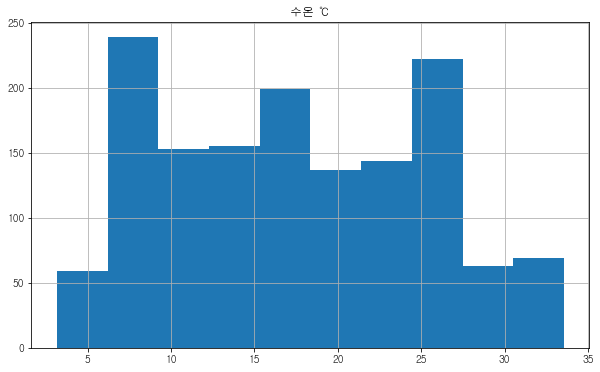

In [35]:
scb_df_daily_15.hist(column='수온 ℃')

array([[<AxesSubplot:title={'center':'방류량(㎥/s)'}>]], dtype=object)

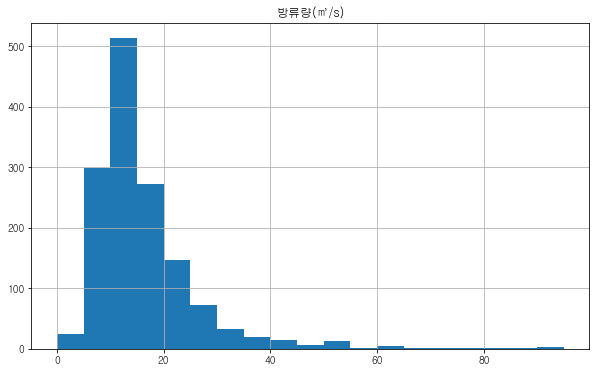

In [36]:
scb_df_daily_15.hist(column='방류량(㎥/s)', bins=range(0, 100, 5))

클로로필-a의 수치가 25 이상 2주동안 지속되는 경우는 다음과 같다.

In [37]:
mask25 = scb_df_daily['클로로필-a mg/㎥'].rolling(window=14).min() >= 25

scb_df_daily[mask25].describe()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
count,984.000000,984.000000,918.000000,954.000000,946.000000,988.000000,988.000000,988.000000
mean,16.363852,378.136313,4.625165,5.979717,0.111937,73.168973,6.621110,17.021436
std,8.049048,73.616102,0.908443,2.149805,0.063883,30.368973,0.851653,22.204984
min,3.154167,150.708333,2.737500,1.019625,0.007583,25.070833,5.337917,0.000000
25%,8.998201,322.020833,4.004212,4.385604,0.070302,48.447431,5.966806,9.749427
50%,15.306250,384.496212,4.491667,5.958792,0.097957,70.743750,6.040590,12.640833
75%,23.918845,439.835227,5.156399,7.610850,0.136988,92.559375,7.505642,18.554219
max,33.571429,559.000000,8.536842,12.105417,0.601174,184.663158,7.671319,527.370694


클로로필-a의 수치가 100 이상 2주동안 지속되는 시기를 확인하면
평균 수온이 7~8도 정도인 경우도 존재한다.

array([[<AxesSubplot:title={'center':'수온 ℃'}>]], dtype=object)

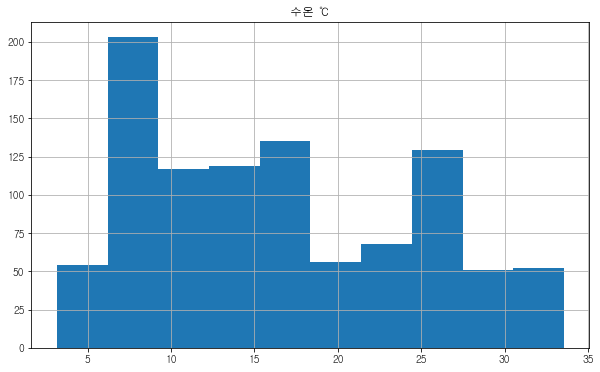

In [38]:
scb_df_daily[mask25].hist(column='수온 ℃')

array([[<AxesSubplot:title={'center':'방류량(㎥/s)'}>]], dtype=object)

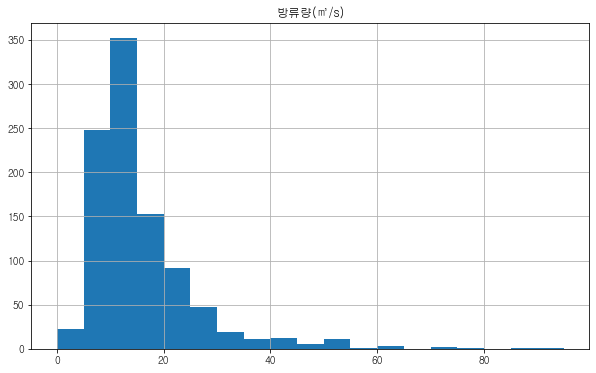

In [39]:
scb_df_daily[mask25].hist(column='방류량(㎥/s)', bins=range(0, 100, 5))

클로로필-a의 수치가 50 이상 2주동안 지속되는 경우는 다음과 같다.

In [40]:
mask50 = scb_df_daily['클로로필-a mg/㎥'].rolling(window=14).min() >= 50

scb_df_daily[mask50].describe()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
count,295.000000,295.000000,273.000000,284.000000,280.000000,299.000000,299.000000,299.000000
mean,14.411360,400.709529,5.004242,6.654920,0.101800,98.168148,6.218915,13.278674
std,7.919687,54.748235,0.878793,2.189976,0.049811,26.636481,0.720535,11.941054
min,4.733333,243.500000,3.150000,2.337600,0.015875,52.078261,5.337917,0.000000
25%,7.585417,361.038949,4.356250,4.906134,0.069344,77.412500,5.953819,8.597708
50%,12.578571,413.333333,4.870000,6.576729,0.093354,94.562500,5.990139,10.939236
75%,18.408333,443.895833,5.479167,8.520579,0.117781,117.080616,6.026701,13.580000
max,32.926087,526.739130,7.691304,11.166100,0.390529,184.663158,7.671319,154.341389


클로로필-a의 수치가 50 이상 2주동안 지속되는 시기를 확인하면 다음과 같다.

In [41]:
scb_df_daily[mask50]

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
date/time,,,,,,,,
2013-08-14,32.663636,269.863636,4.100000,2.962625,0.060667,67.104545,7.577639,15.610556
2013-08-15,32.686957,280.869565,4.579167,3.124458,0.065708,70.941667,7.580000,16.280000
2013-08-16,32.526087,291.826087,4.139130,3.375625,0.062833,78.878261,7.580000,16.280000
2013-08-17,32.213043,305.652174,4.325000,3.472250,0.093667,79.320833,7.583681,17.330625
2013-08-18,32.641667,310.958333,4.204167,3.231083,0.109917,82.475000,7.593264,20.071458
...,...,...,...,...,...,...,...,...
2022-02-28,8.965217,435.043478,5.991304,9.401286,0.086952,122.778261,5.953472,6.833333
2022-03-01,9.787500,444.083333,5.991667,NaN,0.078167,119.037500,5.984931,11.018819
2022-03-02,9.736364,449.636364,6.077778,NaN,NaN,117.491667,5.960903,8.955486


수온에 대한 히스토그램을 그려보면, 낮은 수온에서도 클로로필-a 수치가 50이상 2주동안 지속되는 경우가 많음을 알 수 있다.

array([[<AxesSubplot:title={'center':'수온 ℃'}>]], dtype=object)

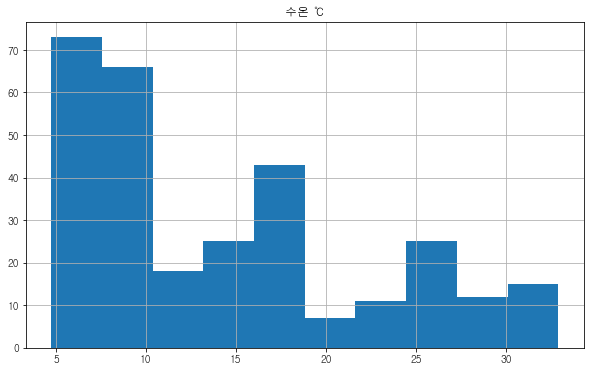

In [42]:
scb_df_daily[mask50].hist(column='수온 ℃')

array([[<AxesSubplot:title={'center':'방류량(㎥/s)'}>]], dtype=object)

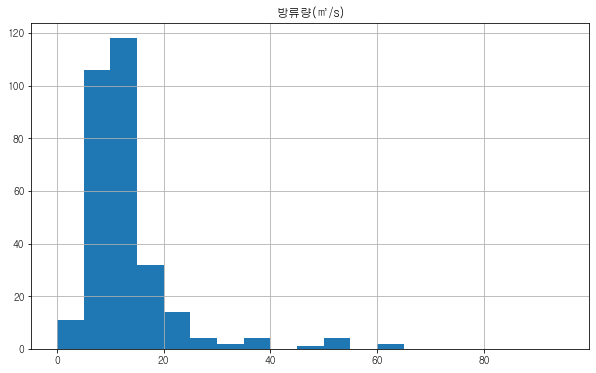

In [43]:
scb_df_daily[mask50].hist(column='방류량(㎥/s)', bins=range(0, 100, 5))

클로로필-a의 수치가 100 이상 2주동안 지속되는 경우는 다음과 같다.

In [44]:
mask100 = scb_df_daily['클로로필-a mg/㎥'].rolling(window=14).min() >= 100

scb_df_daily[mask100].describe()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
count,15.000000,15.000000,14.000000,12.000000,14.000000,15.000000,15.000000,15.000000
mean,7.643970,449.625154,5.595887,10.217116,0.104333,124.862947,5.963903,9.191514
std,1.122911,8.215614,0.534616,0.510460,0.011908,12.234088,0.008860,1.582074
min,6.452174,435.043478,4.875000,9.401286,0.078167,102.059091,5.952986,6.059722
25%,6.790119,443.723485,5.101875,10.026146,0.100462,118.264583,5.958542,8.431493
50%,7.304348,450.250000,5.653152,10.207185,0.105729,122.778261,5.961597,8.917014
75%,8.227083,455.096014,6.083194,10.498991,0.111625,132.651705,5.966806,11.004965
max,9.787500,462.125000,6.275000,11.166100,0.121042,143.304348,5.984931,11.048403


클로로필-a의 수치가 100 이상 2주동안 지속되는 시기를 확인하면 다음과 같이 2022년 2월 중순, 하순이다.
평균 수온이 7~8도 정도임에도 불구하도 높은 클로로필-a 수치가 한동안 유지된 이유는 방류량이
극도로 적은 탓으로 보인다.

In [45]:
scb_df_daily[mask100]

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
date/time,,,,,,,,
2022-02-16,8.083333,452.375000,4.991667,10.063625,0.112500,131.812500,5.959931,8.890486
2022-02-17,7.325000,455.583333,5.137500,10.086625,0.117875,141.195833,5.964792,8.849236
2022-02-18,7.304348,454.608696,5.315000,10.179952,0.109000,142.256522,5.966250,11.048403
2022-02-19,7.062500,455.583333,5.166667,10.702762,0.103542,127.221739,5.956042,8.107431
2022-02-20,6.458333,462.125000,5.075000,10.674091,0.105458,107.775000,5.977847,10.995069
2022-02-21,6.745455,461.636364,5.090000,10.234417,0.106000,102.059091,5.959514,8.917014
2022-02-22,6.834783,452.304348,4.875000,NaN,0.104500,113.804167,5.967361,11.014861
2022-02-23,6.650000,450.250000,NaN,11.166100,0.115000,127.666667,5.957569,6.059722
2022-02-24,6.452174,449.826087,6.275000,10.335700,0.121042,143.304348,5.963403,8.747569


array([[<AxesSubplot:title={'center':'수온 ℃'}>]], dtype=object)

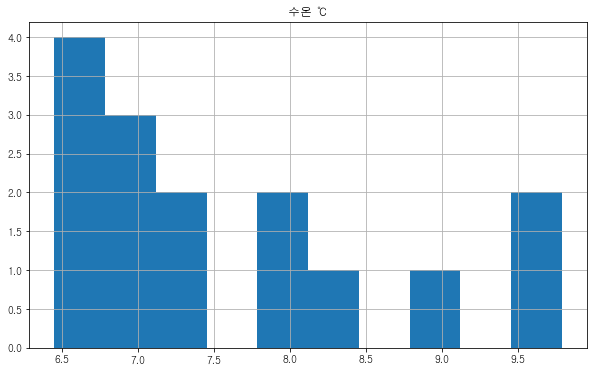

In [46]:
scb_df_daily[mask100].hist(column='수온 ℃')

array([[<AxesSubplot:title={'center':'방류량(㎥/s)'}>]], dtype=object)

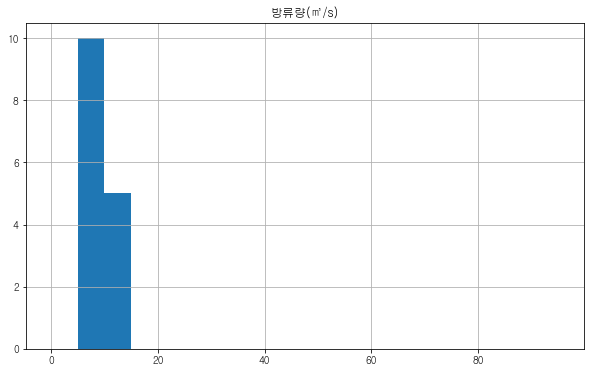

In [47]:
scb_df_daily[mask100].hist(column='방류량(㎥/s)', bins=range(0, 100, 5))

### 클로로필-a 기준에 따른 특성들의 변화

조류 경보 발령 기준별로 특성들의 사분위수 변화를 그래프로 그린다.

In [48]:
def green_tide(quartile='mean', period=14):

    day_quartile_dict = dict()

    for value in range(5, 101, 5):
        mask = scb_df_daily['클로로필-a mg/㎥'].rolling(window=period).min() >= value
        desc = scb_df_daily[mask].describe()
        day_quartile = desc.loc[quartile]
        day_quartile_dict[value] = day_quartile

    day_quartile_df = pd.DataFrame(day_quartile_dict).T
    
    return day_quartile_df

**평균값의 변화**

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

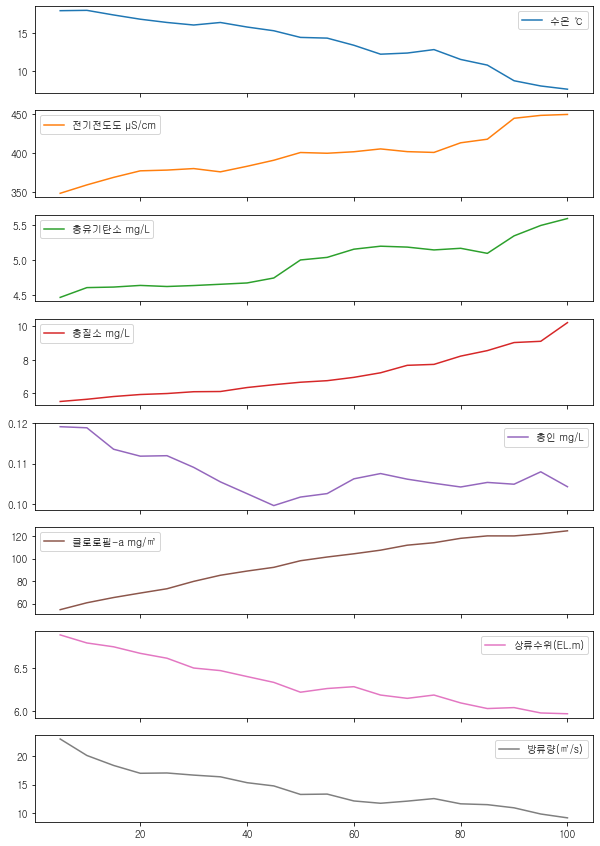

In [49]:
day_quartile_df = green_tide(quartile='mean')
day_quartile_df.plot(subplots=True, figsize=(10, 15))

수온과 방류량만 확인하면 수온이 낮음에도 불구하고 클로로필-a 수치가 높게 오랫동안
유지될 수 있는 이유가 매우 적은 양의 방류량 때문이라는 점을 언급할 수 있다.

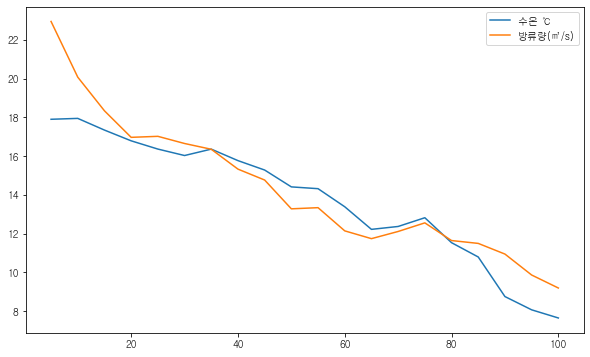

In [50]:
fig = day_quartile_df[['수온 ℃', '방류량(㎥/s)']].plot(figsize=(10, 6))
plt.savefig('temp_flow_rel.png')
plt.show()